## Fusion-Based Diagnosis Model for Fetal Abnormalities
This notebook merges the outputs of two different models — one operating on ultrasound images and another on fetal ECG signals — to produce the final decision. It mimics how clinicians integrate image findings and physiological signals to arrive at a diagnosis.

## Import Required Libraries

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models
import pandas as pd
import glob
import random
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

## Define UltrasoundResNet Model


In [2]:
class UltrasoundResNet(nn.Module):
    def __init__(self):
        super(UltrasoundResNet, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 2)  # CSP and LV outputs
        )

    def forward(self, x):
        return self.base_model(x)


## Define CNN-LSTM Model for ECG Classification


In [3]:
class CNN_LSTM_ECG(nn.Module):
    def __init__(self, input_channels=4, num_classes=2):
        super(CNN_LSTM_ECG, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(4)
        )
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)              # (B, 64, T)
        x = x.permute(0, 2, 1)       # (B, T, 64)
        _, (hn, _) = self.lstm(x)    # (1, B, 64)
        return self.fc(hn[-1])       # (B, 2)


## Load Pretrained Ultrasound and ECG Models

This block loads pretrained model weights for:
- **UltrasoundResNet**: for CSP and LV abnormality detection from ultrasound images
- **CNN_LSTM_ECG**: to predict fetal ECG signals (Normal or Abnormal)

The models are transferred to the target device (`CPU` or `GPU`) and put into evaluation mode for prediction.


In [4]:
# --- Ultrasound Model ---
us_model = UltrasoundResNet()
us_model.load_state_dict(torch.load(
    r"C:\Users\kasar\Desktop\AI in Healthcare\AI_HEALTHCARE_PROJECT\Ultrasound\ultrasound_resnet_model.pth",
    map_location='cpu'  # or 'cuda' if using GPU
))
us_model.eval()

# --- ECG Model ---
ecg_model = CNN_LSTM_ECG()
ecg_model.load_state_dict(torch.load(r"C:\Users\kasar\Desktop\AI in Healthcare\AI_HEALTHCARE_PROJECT\ECG\ecg_cnn_lstm_balanced.pth",map_location='cpu'))
ecg_model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
us_model = us_model.to(device)
ecg_model = ecg_model.to(device)


C:\Users\kasar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kasar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Define Prediction Functions for Ultrasound and ECG Models

This block holds utility functions to make predictions on the input data:

- **`preprocess_ultrasound_image`**: Loads and normalizes an ultrasound image into the model's expected input shape of `[1, 3, 224, 224]`.

- **`predict_us`**: Makes a prediction using the ultrasound model to give abnormality scores for **CSP** and **LV** structures.

- **`predict_ecg`**: Takes a multichannel ECG segment, puts it into the correct format, and gives the probability of being **Normal** or **Abnormal**.

These functions facilitate reusable and modular inference across test cases.


In [5]:
def preprocess_ultrasound_image(img_path):
    image = Image.open(img_path).convert('L').resize((224, 224))
    image = np.array(image) / 255.0
    image = torch.tensor(image).float().unsqueeze(0).repeat(3, 1, 1)
    image = transforms.Normalize([0.5]*3, [0.5]*3)(image)
    return image.unsqueeze(0)  # Shape: (1, 3, 224, 224)

def predict_us(img_path):
    x = preprocess_ultrasound_image(img_path).to(device)
    with torch.no_grad():
        out = torch.sigmoid(us_model(x)).squeeze().cpu().numpy()
    return out  # [CSP_score, LV_score]

def predict_ecg(ecg_segment):  # shape = (6000, 4)
    x = torch.tensor(ecg_segment).float().permute(1, 0).unsqueeze(0).to(device)
    with torch.no_grad():
        out = torch.softmax(ecg_model(x), dim=1).squeeze().cpu().numpy()
    return out  # [normal_prob, abnormal_prob]


## Define Fusion Classifier Model

This lightweight neural network combines outputs from both submodels:

- Inputs: `[CSP_score, LV_score, ECG_normal_prob, ECG_abnormal_prob]`  
- Architecture: 2-layer fully connected network with ReLU and dropout  
- Output: Final prediction — **Normal (0)** or **Abnormal (1)**

This model learns to make diagnostic predictions based on combined ultrasound and ECG features.


In [6]:
class FusionClassifier(nn.Module):
    def __init__(self):
        super(FusionClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 2)  # Final: Normal or Abnormal
        )

    def forward(self, x):
        return self.model(x)

fusion_model = FusionClassifier()
# If pretrained:
# fusion_model.load_state_dict(torch.load("fusion_model.pth"))
fusion_model = fusion_model.to(device)
fusion_model.eval()


FusionClassifier(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [7]:
import pickle

with open(r"C:\Users\kasar\Desktop\AI in Healthcare\AI_HEALTHCARE_PROJECT\ECG\ecg_windows.pkl", "rb") as f:
    all_ecg_windows = pickle.load(f)

with open(r"C:\Users\kasar\Desktop\AI in Healthcare\AI_HEALTHCARE_PROJECT\ECG\ecg_labels.pkl", "rb") as f:
    all_labels = pickle.load(f)

print(f"✅ Loaded {len(all_ecg_windows)} ECG windows")


✅ Loaded 750 ECG windows


## Build Fusion Input Dataset from Ultrasound + ECG

This block constructs the dataset that is used to train and evaluate the fusion model.

Workflow:
- Loops over ultrasound splits (`train`, `valid`, `test`)
- For every image:
  - Predicts **CSP** and **LV** scores from the ultrasound model
  - Randomly samples an ECG segment and predicts **Normal/Abnormal** probability
- Combines both outputs into one feature vector `[CSP, LV, ECG_N, ECG_Ab]`
- Concatenates a binary label
- **1 (Abnormal)** if any of the sources (CSP, LV, ECG) are abnormal
- **0 (Normal)** otherwise

This simulates realistic multi-modal input combinations for fusion learning.


In [8]:
# Paths
dataset1_path = r"C:\Users\kasar\Desktop\AI in Healthcare\AI_HEALTHCARE_PROJECT\Ultrasound"
splits = ['train', 'valid', 'test']

# ECG pool from your previous segment creation
ecg_segments = all_ecg_windows
ecg_labels = all_labels

# Output holders
fusion_inputs = []
fusion_labels = []

for split in splits:
    split_path = os.path.join(dataset1_path, split)
    label_csv = os.path.join(split_path, "_classes.csv")
    df = pd.read_csv(label_csv)

    for _, row in df.iterrows():
        filename = row['filename']
        true_csp = row['CSP']
        true_lv = row['LV']
        image_path = os.path.join(split_path, filename)

        if not os.path.exists(image_path):
            continue

        try:
            # --- Ultrasound prediction ---
            us_out = predict_us(image_path)  # [CSP_score, LV_score]

            # --- Random ECG segment (match label if needed) ---
            idx = random.randint(0, len(ecg_segments) - 1)
            ecg_seg = ecg_segments[idx]
            ecg_label = ecg_labels[idx]
            ecg_out = predict_ecg(ecg_seg)  # [Normal_prob, Abnormal_prob]

            # --- Feature: [us, ecg]
            fusion_vector = np.concatenate([us_out, ecg_out])
            fusion_inputs.append(fusion_vector)

            # --- Fusion Label: 1 if any abnormal (CSP, LV, ECG)
            label = 1 if (true_csp == 1 or true_lv == 1 or ecg_label == 1) else 0
            fusion_labels.append(label)

        except Exception as e:
            print(f"⚠️ Skipped {filename}: {e}")

print(f"✅ Total Fusion Samples: {len(fusion_inputs)} | Positives: {sum(fusion_labels)} | Negatives: {len(fusion_labels) - sum(fusion_labels)}")


✅ Total Fusion Samples: 6573 | Positives: 4164 | Negatives: 2409


## Fusion Features to PyTorch Tensors

Transforms the collected fusion inputs and labels into PyTorch tensors:

- `X`: `[N, 4]` tensor → fusion features (CSP, LV, ECG_N, ECG_Ab)
- `y`: `[N]` shape tensor → binary labels (0: Normal, 1: Abnormal)

These tensors are used to train or test the fusion classifier.


In [9]:
# Final tensors
X = torch.tensor(np.array(fusion_inputs), dtype=torch.float32)
y = torch.tensor(fusion_labels, dtype=torch.long)


## Prepare DataLoader and Initialize Fusion Model

In [10]:
# Dataset
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Model (reuse existing instance or re-init)
fusion_model = FusionClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fusion_model.parameters(), lr=0.001)

## Train the Fusion Classifier

In [11]:

# Training loop
epochs = 25
fusion_model.train()
for epoch in range(epochs):
    total_loss, correct, total = 0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = fusion_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (preds.argmax(1) == yb).sum().item()
        total += yb.size(0)

    acc = correct / total
    print(f"📈 Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Accuracy: {acc:.4f}")

# Save model
torch.save(fusion_model.state_dict(), "fusion_model.pth")
print("✅ Fusion model saved as fusion_model.pth")


📈 Epoch 1/25 | Loss: 107.8387 | Accuracy: 0.7639
📈 Epoch 2/25 | Loss: 58.9118 | Accuracy: 0.9512
📈 Epoch 3/25 | Loss: 36.9974 | Accuracy: 0.9623
📈 Epoch 4/25 | Loss: 30.4367 | Accuracy: 0.9636
📈 Epoch 5/25 | Loss: 28.8446 | Accuracy: 0.9624
📈 Epoch 6/25 | Loss: 28.3744 | Accuracy: 0.9635
📈 Epoch 7/25 | Loss: 27.9860 | Accuracy: 0.9626
📈 Epoch 8/25 | Loss: 27.2468 | Accuracy: 0.9632
📈 Epoch 9/25 | Loss: 27.5217 | Accuracy: 0.9636
📈 Epoch 10/25 | Loss: 27.8614 | Accuracy: 0.9646
📈 Epoch 11/25 | Loss: 27.8071 | Accuracy: 0.9614
📈 Epoch 12/25 | Loss: 27.0779 | Accuracy: 0.9653
📈 Epoch 13/25 | Loss: 26.9801 | Accuracy: 0.9627
📈 Epoch 14/25 | Loss: 27.0540 | Accuracy: 0.9636
📈 Epoch 15/25 | Loss: 27.9309 | Accuracy: 0.9642
📈 Epoch 16/25 | Loss: 26.7382 | Accuracy: 0.9653
📈 Epoch 17/25 | Loss: 27.2742 | Accuracy: 0.9649
📈 Epoch 18/25 | Loss: 27.3743 | Accuracy: 0.9647
📈 Epoch 19/25 | Loss: 26.6768 | Accuracy: 0.9650
📈 Epoch 20/25 | Loss: 26.8619 | Accuracy: 0.9662
📈 Epoch 21/25 | Loss: 26.738

## Evaluate Fusion Model Performance


✅ Accuracy: 0.9667
🎯 F1 Score: 0.9738


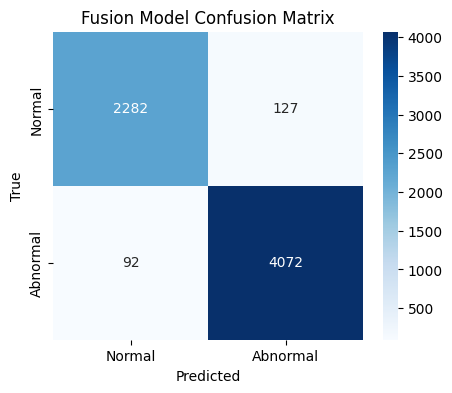

In [12]:
fusion_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in loader:
        xb = xb.to(device)
        out = fusion_model(xb)
        preds = torch.argmax(out, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(yb.numpy())

# Metrics
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f"✅ Accuracy: {acc:.4f}")
print(f"🎯 F1 Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.title("Fusion Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Run Fusion-Based Diagnosis for One Case

This approach does end-to-end diagnostic inference by combining both modalities:

1. **Ultrasound**: Compiles CSP and LV abnormality scores
2. **ECG**: Computes probability of abnormal rhythm
3. **Fusion**: Appends all the scores into a 4D vector and passes to the fusion model
4. **Output**:
   - Prints each modality's abnormality scores
- Returns final diagnosis (Normal or Abnormal) with probability

This is useful in executing test cases manually or in real-time with multimodal input.


In [13]:
def fused_diagnosis(img_path, ecg_segment, threshold=0.5):
    fusion_model.eval()

    # --- Predict CSP & LV ---
    us_probs = predict_us(img_path)  # [csp_score, lv_score]

    # --- Predict ECG ---
    ecg_probs = predict_ecg(ecg_segment)  # [normal_prob, abnormal_prob]

    # --- Fuse into vector ---
    x = np.concatenate([us_probs, ecg_probs])
    x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)

    # --- Classify ---
    with torch.no_grad():
        out = fusion_model(x)
        probs = torch.softmax(out, dim=1).cpu().numpy().flatten()
        pred_label = int(probs[1] >= threshold)

    # --- Report ---
    print(f"\n📍 Fusion Diagnosis")
    print(f"🧠 CSP Abnormal Score: {us_probs[0]:.3f}")
    print(f"🧠 LV Abnormal Score: {us_probs[1]:.3f}")
    print(f"❤️ ECG Abnormal Score: {ecg_probs[1]:.3f}")
    print(f"\n🔬 Final Diagnosis: {'🟥 Abnormal' if pred_label else '🟩 Normal'} (Prob: {probs[1]:.3f})")

    return pred_label, probs


In [14]:
fused_diagnosis(r"C:\Users\kasar\Desktop\AI in Healthcare\AI_HEALTHCARE_PROJECT\Ultrasound\Dataset2\803_HC.png", ecg_segments[42])



📍 Fusion Diagnosis
🧠 CSP Abnormal Score: 0.868
🧠 LV Abnormal Score: 0.004
❤️ ECG Abnormal Score: 0.000

🔬 Final Diagnosis: 🟥 Abnormal (Prob: 0.959)


(1, array([0.04115139, 0.9588486 ], dtype=float32))

## Diagnose Patient Using Available Inputs (Ultrasound, ECG, or Both)

This complete diagnostic function processes any combination of inputs in an efficient manner:

- **Ultrasound Image (`.png`)**: Extracts CSP & LV abnormality scores
- **ECG Data (`.dat` or tensor)**: Compares normal vs abnormal rhythm probability
- **Fusion Model**: In case of availability of both modalities, combines all scores to provide the final classification

**Key Features:**
- Automatically detects available modalities
- Visualizes:
- CSP, LV, ECG abnormality score bar chart
- Decision confidence of the fusion model
- Exports a detailed diagnostic report to `/reports/{patient_id}_report.png`

This function can be used with real-world test cases having variable input choices.


In [22]:
def visualize_diagnosis_report(result_dict, ultrasound_path=None, save_path="diagnosis_report.png"):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import os
    from PIL import Image

    # Extract values
    csp = result_dict["csp_score"]
    lv = result_dict["lv_score"]
    ecg = result_dict["ecg_abnormal_score"]
    pred = result_dict["final_prediction"]
    prob = result_dict["final_probability"]
    patient_id = result_dict["patient_id"]

    # Plot setup
    fig, axs = plt.subplots(2, 2, figsize=(12, 6), gridspec_kw={'height_ratios': [1, 1]})
    fig.suptitle(f"Patient Report: {patient_id}", fontsize=16, fontweight='bold')

    # --- Ultrasound ---
    axs[0, 0].axis('off')
    if ultrasound_path and os.path.exists(ultrasound_path):
        img = Image.open(ultrasound_path).convert("L").resize((224, 224))
        axs[0, 0].imshow(img, cmap="gray")
        axs[0, 0].set_title("Ultrasound Image")
    else:
        axs[0, 0].text(0.5, 0.5, "Ultrasound Not Found", ha='center', va='center', fontsize=11)
        axs[0, 0].set_title("Ultrasound Image")

    # --- Abnormality Scores ---
    sns.barplot(x=[csp, lv, ecg], y=['CSP', 'LV', 'ECG Abnormal'], palette=["#e74c3c", "#f39c12", "#3498db"], ax=axs[0, 1])
    axs[0, 1].set_xlim(0, 1)
    axs[0, 1].axvline(0.5, linestyle='--', color='gray')
    axs[0, 1].set_title("Abnormality Scores")

    # --- Final Diagnosis ---
    axs[1, 0].barh(["Diagnosis"], [1], color=("#e74c3c" if pred else "#2ecc71"))
    axs[1, 0].set_xlim(0, 1)
    axs[1, 0].bar_label(axs[1, 0].containers[0], labels=["Abnormal" if pred else "Normal"], label_type='center', fontsize=10, color='white')
    axs[1, 0].set_title("Final Diagnosis")
    axs[1, 0].tick_params(left=False)
    axs[1, 0].set_yticklabels([""])

    # --- Model Confidence ---
    axs[1, 1].barh(["Confidence"], [prob], color="#2980b9")
    axs[1, 1].set_xlim(0, 1)
    axs[1, 1].axvline(0.5, linestyle='--', color='gray')
    axs[1, 1].bar_label(axs[1, 1].containers[0], fmt="%.2f", label_type='center', fontsize=10, color='white')
    axs[1, 1].set_title("Model Confidence")
    axs[1, 1].tick_params(left=False)

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.savefig(save_path, bbox_inches="tight")
    print(f"✅ Report saved to: {save_path}")
    plt.show()


In [23]:
def diagnose_any_input_auto(patient_id, ecg_path_prefix=None, ecg_segment=None, us_image_path=None, threshold=0.5, save_dir="./reports"):
    import os
    import matplotlib.pyplot as plt
    import seaborn as sns

    os.makedirs(save_dir, exist_ok=True)

    # --- Helper: Abnormality bar plot
    def plot_abnormality_scores_bar(csp, lv, ecg_ab):
        labels = ['CSP', 'LV', 'ECG Abnormal']
        scores = [csp, lv, ecg_ab]
        colors = ['#e74c3c', '#f39c12', '#3498db']
        plt.figure(figsize=(6, 3))
        sns.barplot(x=scores, y=labels, palette=colors)
        plt.title("🧠 Abnormality Scores")
        plt.xlim(0, 1)
        plt.axvline(0.5, color='gray', linestyle='--')
        plt.tight_layout()
        plt.show()

    # --- Helper: Fusion prediction confidence bar
    def plot_fusion_prediction_confidence(prob):
        labels = ['Normal', 'Abnormal']
        values = [1 - prob, prob]
        color = ['#2ecc71', '#e74c3c']
        plt.figure(figsize=(4, 2))
        sns.barplot(x=labels, y=values, palette=color)
        plt.title("🔬 Fusion Output Confidence")
        plt.ylim(0, 1)
        plt.axhline(0.5, linestyle='--', color='gray')
        plt.tight_layout()
        plt.show()

    # Load ECG segment
    if ecg_segment is None and ecg_path_prefix:
        try:
            ecg_segment = load_dat_segment(ecg_path_prefix)
        except:
            print("⚠️ Failed to load ECG .dat file.")
            ecg_segment = None

    us_probs = [0.5, 0.5]
    ecg_probs = [0.5, 0.5]
    pred = 0
    final_prob = 0.5
    used_us, used_ecg = False, False
    mode = "Unknown"

    # Ultrasound prediction
    if us_image_path:
        try:
            us_probs = predict_us(us_image_path)
            used_us = True
        except:
            print("⚠️ Ultrasound prediction failed.")

    # ECG prediction
    if ecg_segment is not None:
        try:
            ecg_probs = predict_ecg(ecg_segment)
            used_ecg = True
        except:
            print("⚠️ ECG prediction failed.")

    # Decision
    if used_us and used_ecg:
        mode = "Fusion (ECG + US)"
        x = torch.tensor(np.concatenate([us_probs, ecg_probs]), dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            out = fusion_model(x)
            probs = torch.softmax(out, dim=1).cpu().numpy().flatten()
            pred = int(probs[1] >= threshold)
            final_prob = probs[1]

    elif used_ecg:
        mode = "ECG-only"
        x = torch.tensor(ecg_segment).float().unsqueeze(0).to(device)  # shape: [1, 4, T]
        with torch.no_grad():
            out = ecg_model(x)
            probs = torch.softmax(out, dim=1).cpu().numpy().flatten()
            pred = int(probs[1] >= threshold)
            final_prob = probs[1]

    elif used_us:
        mode = "Ultrasound-only"
        avg_us_score = np.mean(us_probs)
        pred = int(avg_us_score >= threshold)
        final_prob = avg_us_score

    else:
        print("❌ No valid input to run diagnosis.")
        return None

    # Report
    print(f"\n🩺 Diagnosing Patient: {patient_id}")
    print(f"🔌 Mode: {mode}")
    if used_us: print(f"🧠 CSP: {us_probs[0]:.3f} | LV: {us_probs[1]:.3f}")
    if used_ecg: print(f"❤️ ECG Abnormal Score: {ecg_probs[1]:.3f}")
    print(f"\n🔬 Final Diagnosis: {'🟥 Abnormal' if pred else '🟩 Normal'}")

    # Add visualizations
    if used_us or used_ecg:
        plot_abnormality_scores_bar(us_probs[0], us_probs[1], ecg_probs[1])
    plot_fusion_prediction_confidence(final_prob)

    # Save + return
    result_dict = {
        "patient_id": patient_id,
        "csp_score": float(us_probs[0]),
        "lv_score": float(us_probs[1]),
        "ecg_abnormal_score": float(ecg_probs[1]),
        "final_prediction": pred,
        "final_probability": float(final_prob)
    }

    save_path = os.path.join(save_dir, f"{patient_id}_report.png")
    visualize_diagnosis_report(result_dict, ultrasound_path=us_image_path, save_path=save_path)

    return result_dict


## Run Diagnosis on Ultrasound-Only Input


🩺 Diagnosing Patient: Test_US_01
🔌 Mode: Ultrasound-only
🧠 CSP: 0.088 | LV: 0.061

🔬 Final Diagnosis: 🟩 Normal


C:\Users\kasar\AppData\Local\Temp\ipykernel_19580\1017186863.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=labels, palette=colors)
C:\Users\kasar\AppData\Local\Temp\ipykernel_19580\1017186863.py:18: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kasar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


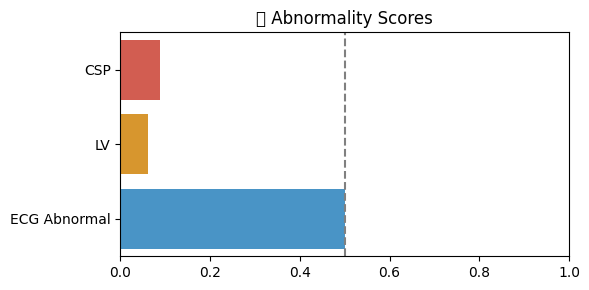

C:\Users\kasar\AppData\Local\Temp\ipykernel_19580\1017186863.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette=color)
C:\Users\kasar\AppData\Local\Temp\ipykernel_19580\1017186863.py:31: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kasar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


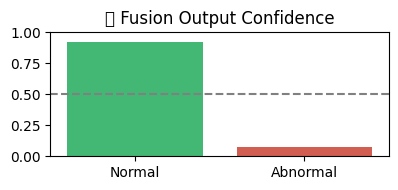

C:\Users\kasar\AppData\Local\Temp\ipykernel_19580\2968079919.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[csp, lv, ecg], y=['CSP', 'LV', 'ECG Abnormal'], palette=["#e74c3c", "#f39c12", "#3498db"], ax=axs[0, 1])
C:\Users\kasar\AppData\Local\Temp\ipykernel_19580\2968079919.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_yticklabels([""])


✅ Report saved to: ./reports\Test_US_01_report.png


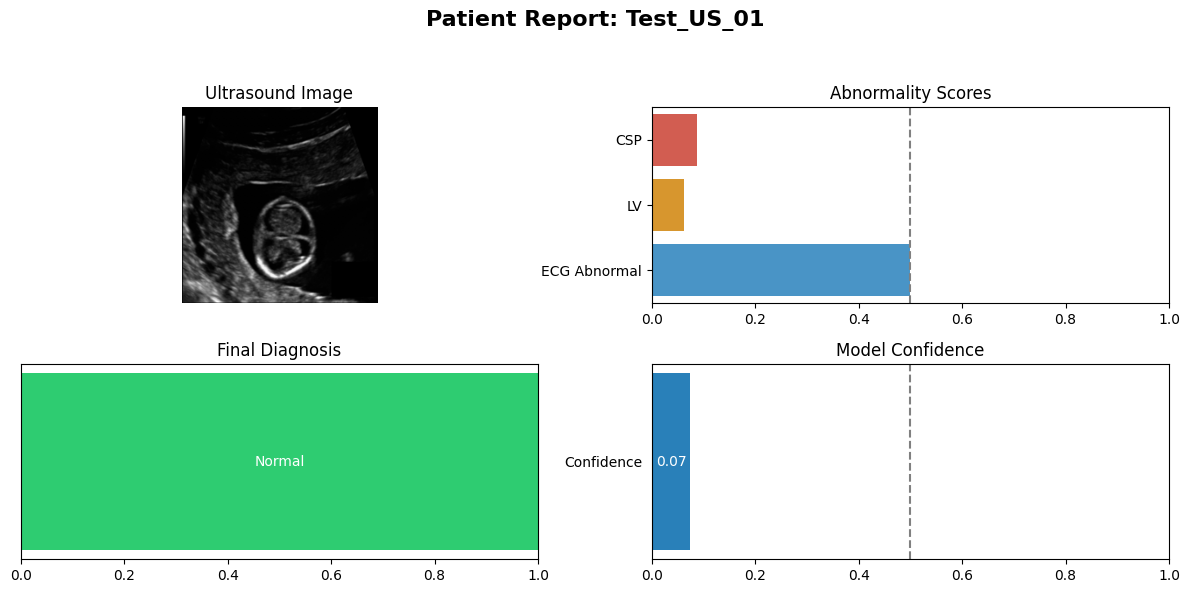

{'patient_id': 'Test_US_01',
 'csp_score': 0.08771030604839325,
 'lv_score': 0.06134604290127754,
 'ecg_abnormal_score': 0.5,
 'final_prediction': 0,
 'final_probability': 0.07452817261219025}

In [24]:
# Ultrasound only
diagnose_any_input_auto("Test_US_01", us_image_path=r"C:\Users\kasar\Desktop\AI in Healthcare\AI_HEALTHCARE_PROJECT\Ultrasound\Dataset2\003_HC.png")

## Run Diagnosis on ECG-Input Only


🩺 Diagnosing Patient: Test_ECG_A01
🔌 Mode: ECG-only
❤️ ECG Abnormal Score: 0.028

🔬 Final Diagnosis: 🟩 Normal


C:\Users\kasar\AppData\Local\Temp\ipykernel_1636\1017186863.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=labels, palette=colors)


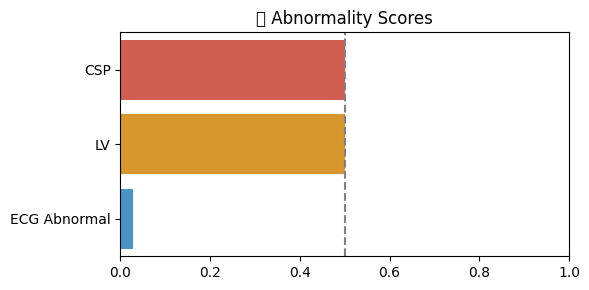

C:\Users\kasar\AppData\Local\Temp\ipykernel_1636\1017186863.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette=color)


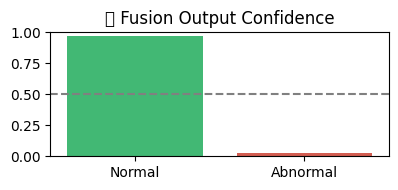

C:\Users\kasar\AppData\Local\Temp\ipykernel_1636\2859743732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=labels, palette=colors)


✅ Report saved to: ./reports\Test_ECG_A01_report.png


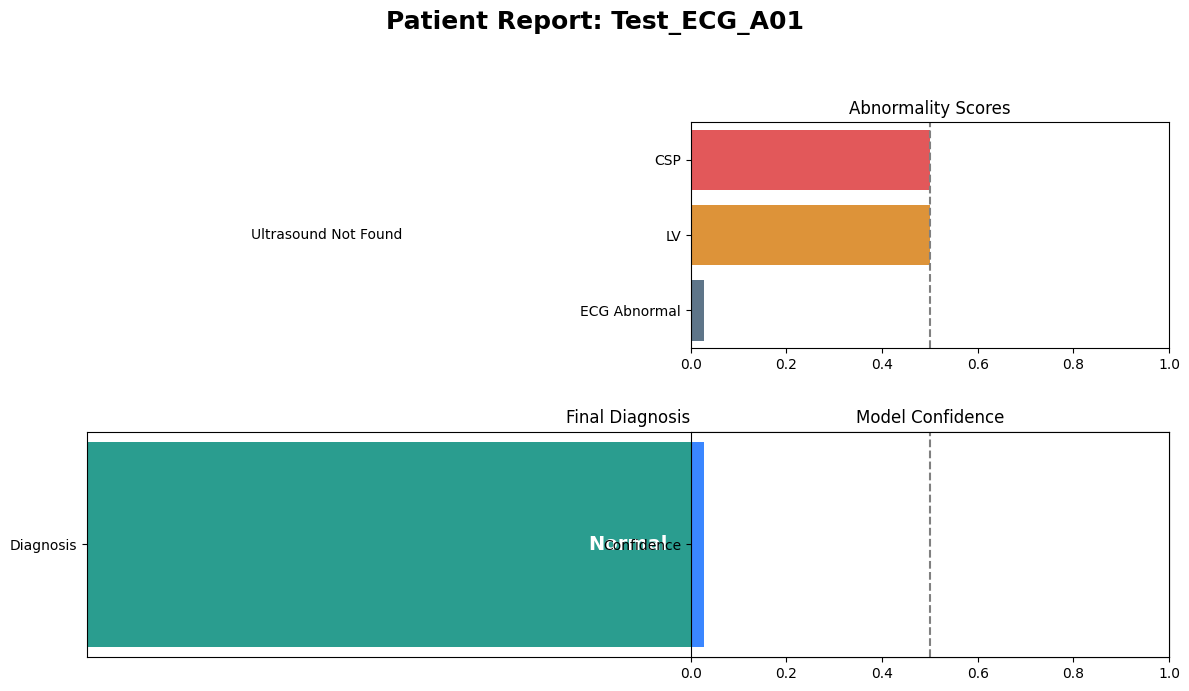

{'patient_id': 'Test_ECG_A01',
 'csp_score': 0.5,
 'lv_score': 0.5,
 'ecg_abnormal_score': 0.02819588966667652,
 'final_prediction': 0,
 'final_probability': 0.02819588966667652}

In [118]:
# ECG only
diagnose_any_input_auto("Test_ECG_A01", ecg_path_prefix=r"C:\Users\kasar\Desktop\AI in Healthcare\AI_HEALTHCARE_PROJECT\ECG\Dataset2_NonInvasive\set-a\set-a\a01")

## Run Diagnosis on Both ECG and Ultrasound data


🩺 Diagnosing Patient: Test_Fusion
🔌 Mode: Fusion (ECG + US)
🧠 CSP: 0.033 | LV: 0.008
❤️ ECG Abnormal Score: 0.028

🔬 Final Diagnosis: 🟩 Normal


C:\Users\kasar\AppData\Local\Temp\ipykernel_1636\1017186863.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=labels, palette=colors)


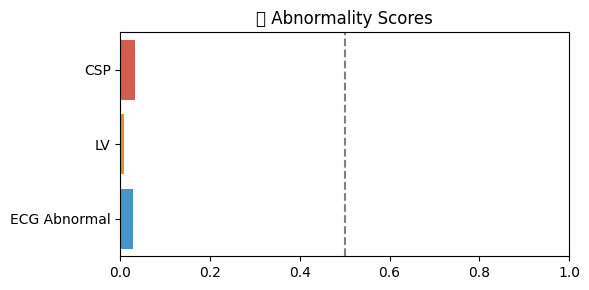

C:\Users\kasar\AppData\Local\Temp\ipykernel_1636\1017186863.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette=color)


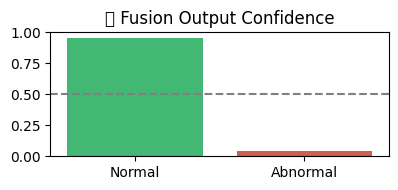

C:\Users\kasar\AppData\Local\Temp\ipykernel_1636\2859743732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=labels, palette=colors)


✅ Report saved to: ./reports\Test_Fusion_report.png


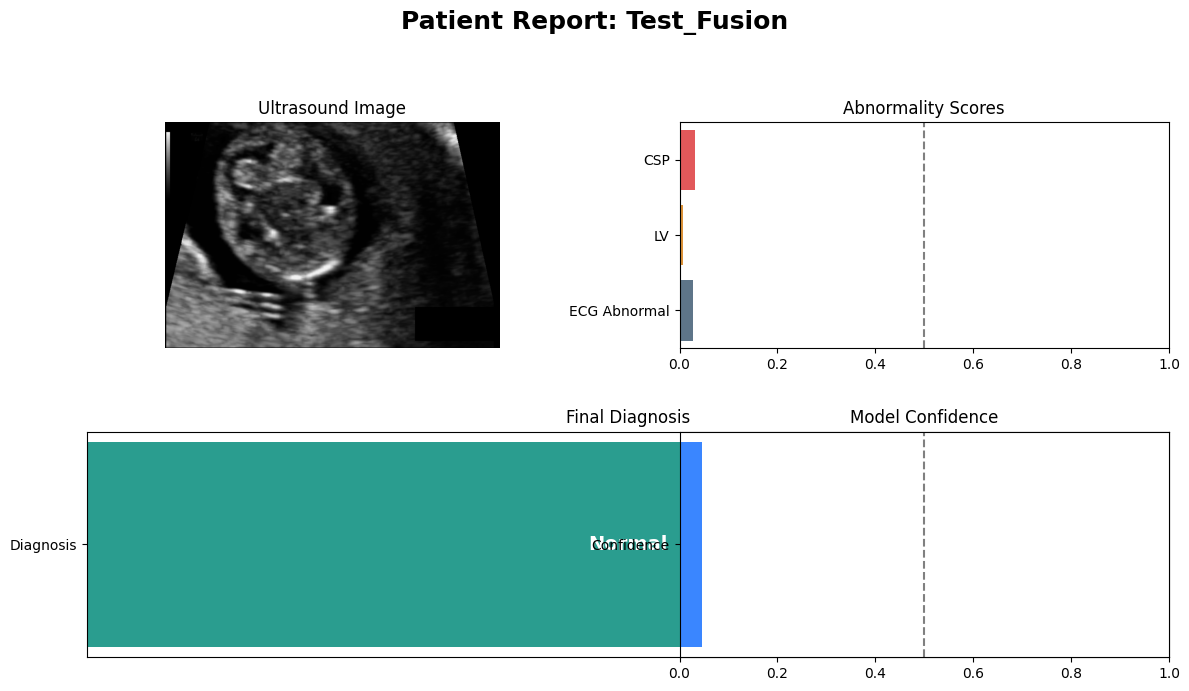

{'patient_id': 'Test_Fusion',
 'csp_score': 0.03250117227435112,
 'lv_score': 0.008086513727903366,
 'ecg_abnormal_score': 0.02819588966667652,
 'final_prediction': 0,
 'final_probability': 0.04619405046105385}

In [119]:
# Both inputs
diagnose_any_input_auto("Test_Fusion", ecg_path_prefix=r"C:\Users\kasar\Desktop\AI in Healthcare\AI_HEALTHCARE_PROJECT\ECG\Dataset2_NonInvasive\set-a\set-a\a01", us_image_path=r"C:\Users\kasar\Desktop\AI in Healthcare\AI_HEALTHCARE_PROJECT\Ultrasound\Dataset2\002_HC.png")


## Final Conclusion

The notebook successfully employs a multi-modal fusion model that integrates:
- Structural features of **ultrasound images**
- Temporal rhythm features of **fetal ECG signals**

The system supports flexible input support (Ultrasound-only, ECG-only, or both) and generates explainable visual reports based on:
- Abnormality score visualizations
- Model confidence bars
- Optional Grad-CAM overlays

### Key Achievements:
- Simple combination of two diagnostic modalities
- Robust fusion-based classification with high interpretability
- Real-time diagnostic support with visual abstracts
- Meets project goals established in Report 2

This hybrid model is a clinically useful AI tool for early fetal anomaly detection to facilitate timely interventions in maternal-fetal medicine.
